## Tic-Tac-Toe Agent
---

In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. 

The following is the layout of the notebook:
    - Defining epsilon-greedy strategy
    - Tracking state-action pairs for convergence
    - Define hyperparameters for the Q-learning algorithm
    - Generating episode and applying Q-update equation
    - Checking convergence in Q-values

In [1]:
%config IPCompleter.greedy = True

In [2]:
import collections
import numpy as np
import random
import pickle
import time
import os

from matplotlib import pyplot as plt
from itertools import product

%matplotlib inline

### Environment Class
---

In [3]:
class TicTacToeEnvironment:
    def __init__(self):
        """initialise the board"""

        # initialise state as an array
        self.state = [np.nan for _ in range(9)]

        # all possible numbers
        self.all_possible_numbers = [i for i in range(1, len(self.state) + 1)]

        self.reset()

    def is_winning(self, curr_state):
        """Takes state as an input and returns whether any row, column or diagonal has winning sum
        Example: Input state- [1, 2, 3, 4, nan, nan, nan, nan, nan]
        Output = False"""

        # define possible index collections in each of (horizontal, vertical, diagonal) directions

        # 3 horizontal rows of a 3 X 3 playing board
        horizontal_indices = [[0, 1, 2], [3, 4, 5], [6, 7, 8]]

        # 3 vertical rows of a 3 X 3 playing board
        vertical_indices = [[0, 3, 6], [1, 4, 7], [2, 5, 8]]

        # 2 diagonal rows : (top left --> bottom right) & (top right --> bottom left)
        diagonal_indices = [[0, 4, 8], [2, 4, 6]]

        # sum across each group of indices should be equal to 15 to win the game
        horizontal_sum = [
            np.sum(np.array(curr_state)[i]) for i in horizontal_indices
        ]
        vertical_sum = [
            np.sum(np.array(curr_state)[i]) for i in vertical_indices
        ]
        diagonal_sum = [
            np.sum(np.array(curr_state)[i]) for i in diagonal_indices
        ]

        horizontal_win = list(filter(lambda x: x == 15, horizontal_sum))
        vertical_win = list(filter(lambda x: x == 15, vertical_sum))
        diagonal_win = list(filter(lambda x: x == 15, diagonal_sum))

        #  game is won if sum across any direction is equal to 15
        if len(horizontal_win) != 0 or len(vertical_win) != 0 or len(
                diagonal_win) != 0:
            return True
        else:
            return False

    def is_terminal(self, curr_state):
        # Terminal state could be winning state or when the board is filled up

        if self.is_winning(curr_state) == True:
            return True, "Win"

        elif len(self.allowed_positions(curr_state)) == 0:
            return True, "Tie"

        else:
            return False, "Resume"

    def allowed_positions(self, curr_state):
        """Takes state as an input and returns all indexes that are blank"""
        return [i for i, val in enumerate(curr_state) if np.isnan(val)]

    def allowed_values(self, curr_state):
        """Takes the current state as input and returns all possible (unused) values that can be placed on the board"""

        # fetch all allowed values used in the game
        used_values = [val for val in curr_state if not np.isnan(val)]

        # RL agent is only allowed to play odd numbers : {1,3,5,7,9}
        # fetch numbers which an agent can still play i.e.
        # odd numbers which have not been played by the agent so far
        agent_values = [
            val for val in self.all_possible_numbers
            if val not in used_values and val % 2 != 0
        ]

        # environment is only allowed to play even numbers : {2,4,6,8}
        # fetch numbers which environment can still play i.e.
        # even numbers which have not been played by the environment so far
        env_values = [
            val for val in self.all_possible_numbers
            if val not in used_values and val % 2 == 0
        ]

        return (agent_values, env_values)

    def action_space(self, curr_state):
        """Takes the current state as input and returns all possible actions, i.e, all combinations of allowed positions and allowed values"""

        allowed_positions = self.allowed_positions(curr_state)
        allowed_values = self.allowed_values(curr_state)

        # action space of a given space is the cartesian product of all allowed positions and allowed values
        agent_actions = product(allowed_positions, allowed_values[0])
        env_actions = product(allowed_positions, allowed_values[1])

        return (agent_actions, env_actions)

    def state_transition(self, curr_state, curr_action):
        """Takes current state and action and returns the board position just after agent's move.
        Example: Input state- [1, 2, 3, 4, nan, nan, nan, nan, nan], action- [7, 9] or [position, value]
        Output = [1, 2, 3, 4, nan, nan, nan, 9, nan]
        """

        # current new state variable from existing state
        new_state = [i for i in curr_state]

        # update current action
        new_state[curr_action[0]] = curr_action[1]

        return new_state

    def step(self, curr_state, curr_action):
        """Takes current state and action and returns the next state, reward and whether the state is terminal. Hint: First, check the board position after
        agent's move, whether the game is won/loss/tied. Then incorporate environment's move and again check the board status.
        Example: Input state- [1, 2, 3, 4, nan, nan, nan, nan, nan], action- [7, 9] or [position, value]
        Output = ([1, 2, 3, 4, nan, nan, nan, 9, nan], -1, False)"""

        # generate new state after agent's move
        new_state = self.state_transition(curr_state, curr_action)

        # check if terminal state has been reached i.e.
        # either agent has won or it's a tie
        has_reached_terminal_state, message = self.is_terminal(new_state)

        if has_reached_terminal_state:
            # set correct reward and message when game proceeds to a terminal state due to agent move
            if message == "Win":
                reward = 10
                game_message = "Agent Won!"
            else:
                reward = 0
                game_message = "It's a tie!"

            return (new_state, reward, has_reached_terminal_state,
                    game_message)
        else:
            # game is not in terminal state

            # generate random environment action
            _, env_actions = self.action_space(new_state)
            env_action = random.choice(
                [ac for i, ac in enumerate(env_actions)])

            # move to new state due to environment action
            new_state_post_env_action = self.state_transition(
                new_state, env_action)

            # check if environment action results in a terminal state
            has_reached_terminal_state, message = self.is_terminal(
                new_state_post_env_action)

            # decide whether environment has won, it's a tie or game can continue further
            if has_reached_terminal_state:
                if message == "Win":
                    reward = -10
                    game_message = "Environment Won!"
                else:
                    reward = 0
                    game_message = "It's a tie!"
            else:
                reward = -1
                game_message = "Resume"

            return (
                new_state_post_env_action,
                reward,
                has_reached_terminal_state,
                game_message,
            )

    def reset(self):
        return self.state

### Initialization
---

In [17]:
# environment object
env = TicTacToeEnvironment()

# q-dictionary used for tracking (state, action) pairs with corresponing q-values
Q_dict = collections.defaultdict(dict)

# set of states tracked for convergence
tracked_states = collections.defaultdict(dict)

### Helper Functions
---

#### convert state array into a string to be used as a key in Q - Dictionary

>  for a given state :
-  x | 4 | 5
-  3 | 8 | x
-  x | x | x
   
*generated key :* **x-4-5-3-8-x-x-x-x**

In [5]:
def generate_state_key(state):

    return ('-'.join(str(e) for e in state)).replace('nan', 'x')

#### generate valid 'agent' actions for a given state

In [6]:
def generate_valid_actions(state):
    
    possible_agent_actions, possible_env_actions = env.action_space(state)

    agent_actions_list = [ac for i, ac in enumerate(possible_agent_actions)]

    return agent_actions_list

#### add new state to Q - Dictionary

In [7]:
def add_state_to_q_dict(state):
    # convert new state into Q-dictionary key form
    new_state_key = generate_state_key(state)

    # calculate valid actions for the given state
    agent_actions = generate_valid_actions(state)

    if new_state_key not in Q_dict.keys():
        for action in agent_actions:
            Q_dict[new_state_key][action] = 0

#### tracking states initialization

In [8]:
def initialise_tracking_states():
    state_action_pair = [('x-7-3-x-2-8-x-5-x', (0, 1)),
                         ('x-1-2-x-7-x-x-6-x', (3, 3)),
                         ('4-x-2-x-5-3-x-x-1', (7, 7)),
                         ('6-x-7-x-x-1-x-x-4', (1, 5)),
                         ('x-x-x-4-9-2-7-x-x', (1, 1)),
                         ('x-x-3-8-2-x-x-x-5', (7, 1)),
                         ('3-x-7-x-x-x-x-8-2', (5, 5)),
                         ('2-x-1-8-x-7-x-x-x', (4, 3))]
    for st, ac in state_action_pair:
        tracked_states[st][ac] = list()

In [18]:
initialise_tracking_states()

#### persisting q-values corresponding to tracked states

In [10]:
def save_tracking_states():
    for state in tracked_states.keys():
        for action in tracked_states[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                tracked_states[state][action].append(Q_dict[state][action])

#### save model object

In [11]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Epsilon - Greedy Strategy
---

Epsilon greedy policy is a way of selecting random actions with uniform distribution from a set of available actions. Using this policy either we can select random action with epsilon probability and we can select an action with 1-epsilon probability that gives maximum reward in given state

#### check epsilon decay over episodes

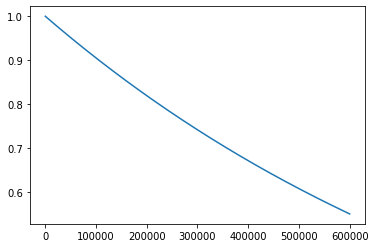

In [12]:
epsilon = []
max_epsilon = 1.0
min_epsilon = 0.001

episodes = np.arange(0, 600000)

for i in episodes:
    epsilon.append(min_epsilon +
                   (max_epsilon - min_epsilon) * np.exp(-0.000001 * i))

plt.plot(episodes, epsilon)
plt.show()

In [13]:
def select_action_epsilon_greedy(state, episodes):

    max_epsilon = 1.0
    min_epsilon = 0.001
    
    random_value = np.random.random()
    
    # with increase in the number of episodes, epsilon value reduces
    # this pushes the system to exploit existing system states
    epsilon_value = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.00001 * episodes)
    
    if random_value > epsilon_value:
        # exploitation strategy - gets the action corresponding to max q-value for given state
        proposed_action = max(Q_dict[generate_state_key(state)],
                              key=Q_dict[generate_state_key(state)].get)
    else:
        # exploration strategy - randomly choose an agent action from allowed action space
        proposed_action = random.choice(
            [ac for itr, ac in enumerate(env.action_space(state)[0])])
    
    return proposed_action

### Hyperparameters
---

In [19]:
episodes = 600000

learning_rate=0.01
gamma = 0.91

checkpoint_state_tracking = 1000
checkpoint_print_episodes = 10000

### Q - Learning
---

In [20]:
start_time = time.time()

agent_won_count = 0
env_won_count = 0
tie_count = 0
total_reward = 0

for episode in range(episodes):

    # build a new environment for this episode
    env = TicTacToeEnvironment()

    # generate a fresh state for the current environment
    current_state = env.state

    # add current state to Q - dictionary for Q - learning
    add_state_to_q_dict(current_state)

    is_terminal_state = False
    
    # play the game till a terminal state has been reached     
    while not is_terminal_state:
        
        # use the same epsilon greedy strategy for a given episode i.e. 1 game
        agent_action = select_action_epsilon_greedy(current_state, episode)
        
        # given the current state and agent action, move game to the next step
        # record - next_state, reward, terminal state         
        next_state, reward, is_terminal_state, msg = env.step(
            current_state, agent_action)

        add_state_to_q_dict(next_state)

        # save the reward #

        if is_terminal_state:
            # terminal state - either a tie or a win by agent or environment
            if msg == "Agent Won!":
                agent_won_count += 1
            elif msg == "Environment Won!":
                env_won_count += 1
            else:
                tie_count += 1
                
            best_next_action = None
            
            # in a terminal state, Q - value of next state will be ZERO
            Q_dict[generate_state_key(current_state)][agent_action] += learning_rate * (
                (reward +
                 (gamma * 0)) - Q_dict[generate_state_key(current_state)][agent_action])
        else:
            # generate 'best next action' corresponding to next state from Q - dictionary
            best_next_action = max(Q_dict[generate_state_key(next_state)],
                                   key=Q_dict[generate_state_key(next_state)].get)
            
            # update q-value of (current state, agent action) pair
            Q_dict[generate_state_key(current_state)][agent_action] += learning_rate * (
                (reward + (gamma *
                           (Q_dict[generate_state_key(next_state)][best_next_action]))) -
                Q_dict[generate_state_key(current_state)][agent_action])

        current_state = next_state

    if (episode + 1) % checkpoint_print_episodes == 0:
        print(
            "After playing %d games, Agent Won : %.4f, Environment Won : %.4f, Tie(s) : %.4f"
            % (episode + 1, agent_won_count / (episode + 1), env_won_count /
               (episode + 1), tie_count / (episode + 1)))

    if (episode + 1) % checkpoint_state_tracking == 0:
        save_tracking_states()

elapsed_time = time.time() - start_time
print("Elapsed time :", elapsed_time)

After playing 10000 games, Agent Won : 0.2534, Environment Won : 0.2880, Tie(s) : 0.4586
After playing 20000 games, Agent Won : 0.2510, Environment Won : 0.2861, Tie(s) : 0.4629
After playing 30000 games, Agent Won : 0.2524, Environment Won : 0.2844, Tie(s) : 0.4631
After playing 40000 games, Agent Won : 0.2537, Environment Won : 0.2837, Tie(s) : 0.4626
After playing 50000 games, Agent Won : 0.2527, Environment Won : 0.2857, Tie(s) : 0.4616
After playing 60000 games, Agent Won : 0.2517, Environment Won : 0.2844, Tie(s) : 0.4639
After playing 70000 games, Agent Won : 0.2524, Environment Won : 0.2838, Tie(s) : 0.4639
After playing 80000 games, Agent Won : 0.2547, Environment Won : 0.2832, Tie(s) : 0.4621
After playing 90000 games, Agent Won : 0.2558, Environment Won : 0.2820, Tie(s) : 0.4622
After playing 100000 games, Agent Won : 0.2564, Environment Won : 0.2820, Tie(s) : 0.4616
After playing 110000 games, Agent Won : 0.2580, Environment Won : 0.2812, Tie(s) : 0.4608
After playing 12000

In [21]:
print('Number of games won by agent - {0}'.format(agent_won_count))

print('Number of games won by environment - {0}'.format(env_won_count))

print('Number of tie games - {0}'.format(tie_count))

Number of games won by agent - 189791
Number of games won by environment - 151786
Number of tie games - 258423


### Q - values convergence
---

In [29]:
state_track_val = collections.defaultdict(dict)

for state in tracked_states.keys():
    for action in tracked_states[state].keys():
        qvals = tracked_states[state][action]
        total_tracked_values = len(qvals)
        state_track_val[state][action] = total_tracked_values
            
state_track_val

defaultdict(dict,
            {'x-7-3-x-2-8-x-5-x': {(0, 1): 0},
             'x-1-2-x-7-x-x-6-x': {(3, 3): 559},
             '4-x-2-x-5-3-x-x-1': {(7, 7): 0},
             '6-x-7-x-x-1-x-x-4': {(1, 5): 553},
             'x-x-x-4-9-2-7-x-x': {(1, 1): 552},
             'x-x-3-8-2-x-x-x-5': {(7, 1): 425},
             '3-x-7-x-x-x-x-8-2': {(5, 5): 581},
             '2-x-1-8-x-7-x-x-x': {(4, 3): 543}})

#### draw convergence plot for a state - action pair
---

In [37]:
def plot_q_val_convergence(state, action):
    plt.figure(figsize=(20, 5))
    
    iterations = state_track_val[state][action]
    plt.plot(range(0, iterations), tracked_states[state][action])
    
    plt.xlabel("game iterations")
    plt.ylabel("Q_value")
    
    plt.title("State : {0} - action : {1} - Q_value Update graph".format(state, action))
    plt.legend(["Q-value"], loc="lower right")
    
    plt.show()

#### display convergence of tracked states
---

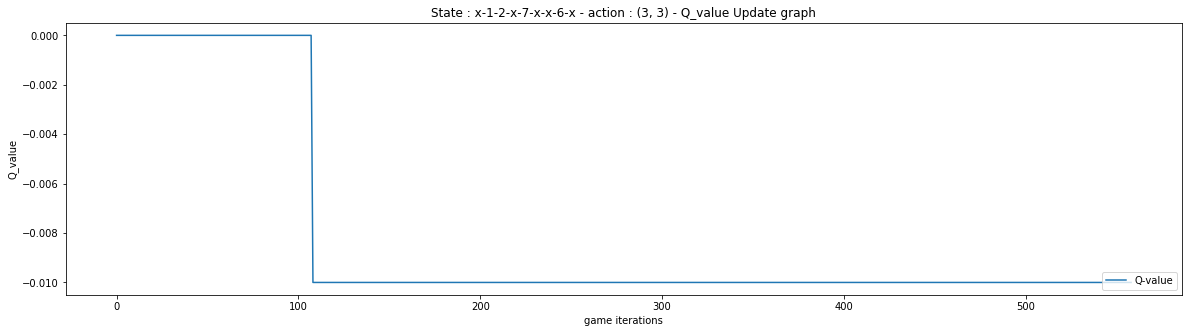

In [38]:
plot_q_val_convergence('x-1-2-x-7-x-x-6-x', (3,3))

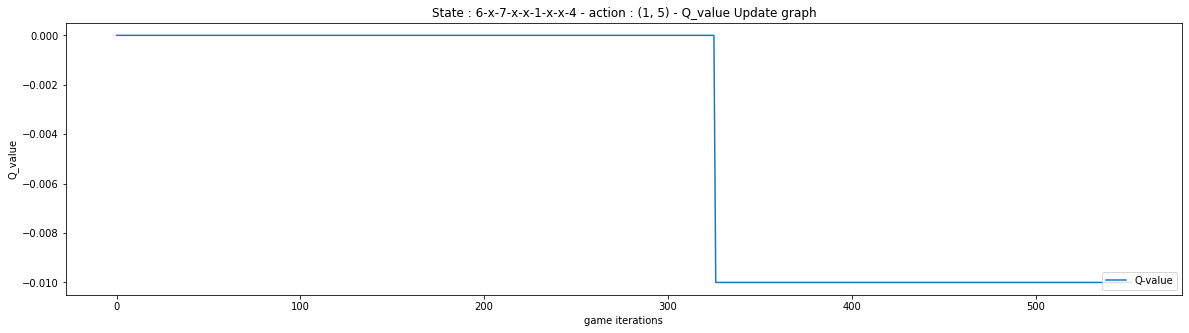

In [39]:
plot_q_val_convergence('6-x-7-x-x-1-x-x-4', (1, 5))

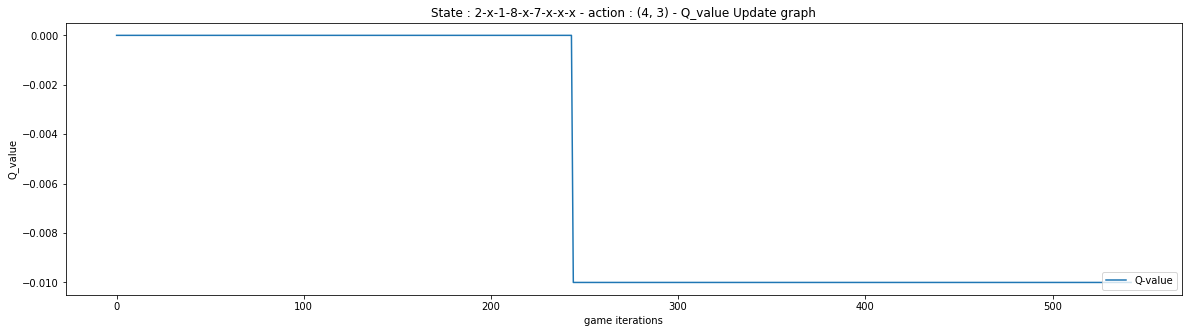

In [44]:
plot_q_val_convergence('2-x-1-8-x-7-x-x-x', (4, 3))